In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adamax

2024-04-13 14:02:47.224273: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 14:02:47.224368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 14:02:47.322604: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
Lung_Opacity = ['/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity']
Normal = ['/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Normal']
Viral_Pneumonia = ['/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/Viral Pneumonia']
file_p = []
labels = []
dict_lists = [Normal, Lung_Opacity,Viral_Pneumonia]
class_labels = ['Normal', 'Lung Opacity','Viral Pneumonia']

for i, dir_list in enumerate(dict_lists):
     for j in dir_list:
            list_f = os.listdir(j)
            for name in list_f:
                fpath = os.path.join(j, name)
                file_p.append(fpath)
                labels.append(class_labels[i])


failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
df = pd.DataFrame(data)

In [3]:
df.head()

,filepaths,labels
0,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
1,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
2,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
3,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal
4,/kaggle/input/lung-disease/Lung X-Ray Image/Lu...,Normal


In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42,stratify=train_df.labels)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(2224, 2)
(695, 2)
(556, 2)


In [5]:
def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    image[:, :, 2] = value

    return image

In [6]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda image: enhance_image(image))
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=32,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(256,256),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=64,
                                    shuffle=False
                                   )

Found 2224 validated image filenames belonging to 3 classes.
Found 695 validated image filenames belonging to 3 classes.
Found 556 validated image filenames belonging to 3 classes.


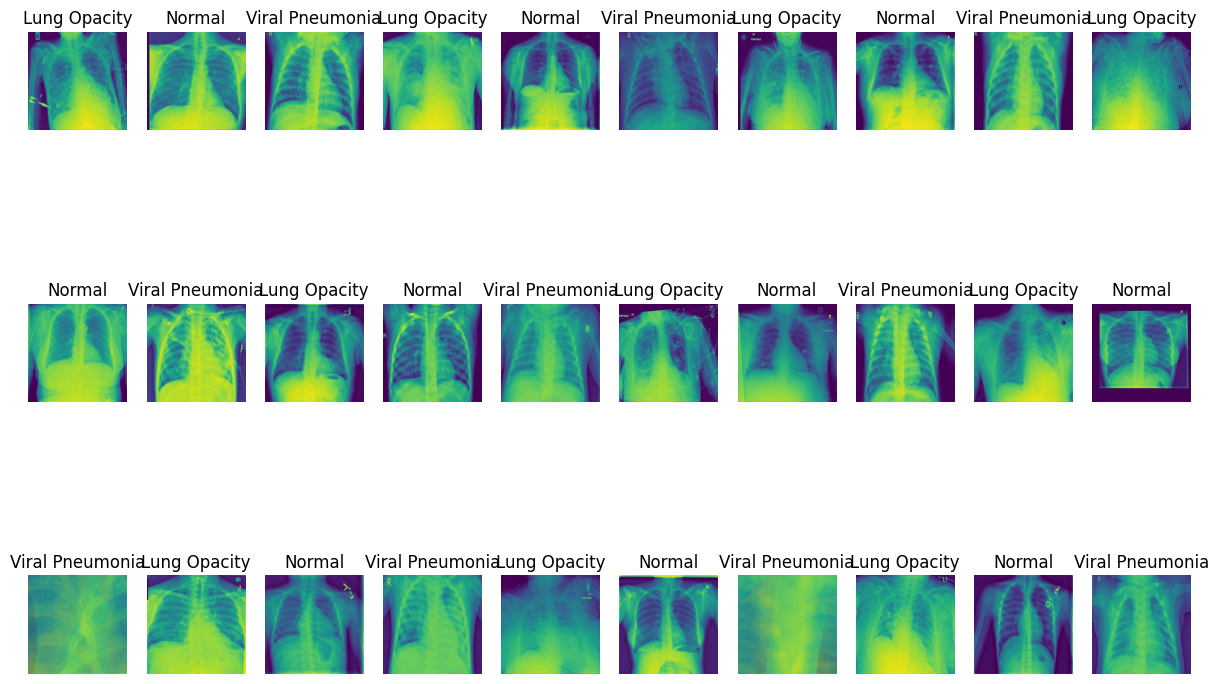

In [7]:
import matplotlib.pyplot as plt

# Define the number of images to display from each class
num_images_per_class = 10

# Get class labels
class_labels = list(train.class_indices.keys())

# Plot images from each class
plt.figure(figsize=(15, 10))
for label in class_labels:
    # Get indices of images belonging to the current class
    indices = train_df[train_df['labels'] == label].index
    
    # Randomly sample a subset of indices if there are more than the desired number of images per class
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)
    
    # Plot images
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        plt.imshow(plt.imread(train_df.loc[idx, 'filepaths']))  # Load and plot the image
        plt.title(label)
        plt.axis('off')
plt.show()


In [12]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
learning_rate = 0.001
base_model = InceptionV3(weights='imagenet', include_top=False,pooling='max')
x = base_model.output
x = Dense(256, activation='relu',)(x)
x = Dropout(0.4)(x) 
predictions = Dense(3, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adamax(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train, epochs=25, validation_data=val)




Epoch 1/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 122s 808ms/step - accuracy: 0.6993 - loss: 1.9443 - val_accuracy: 0.8058 - val_loss: 0.6238
Epoch 2/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - accuracy: 0.9330 - loss: 0.1914 - val_accuracy: 0.8849 - val_loss: 0.3684
Epoch 3/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - accuracy: 0.9622 - loss: 0.1023 - val_accuracy: 0.8651 - val_loss: 0.4458
Epoch 4/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - accuracy: 0.9941 - loss: 0.0277 - val_accuracy: 0.8903 - val_loss: 0.4557
Epoch 5/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - accuracy: 0.9914 - loss: 0.0268 - val_accuracy: 0.9191 - val_loss: 0.3785
Epoch 6/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 201ms/step - accuracy: 0.9913 - loss: 0.0223 - val_accuracy: 0.9119 - val_loss: 0.4501
Epoch 7/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9137 - val_loss: 0.5085
Epoch 8/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - accuracy: 0.9985 - loss: 0.0050 - val_acc

In [13]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - accuracy: 0.9237 - loss: 0.6962
Test Loss: 0.7148125767707825
Test Accuracy: 0.9251798391342163


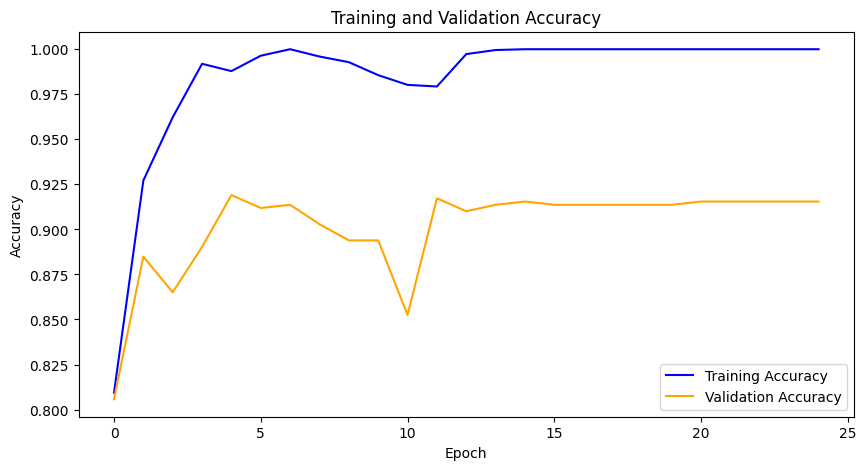

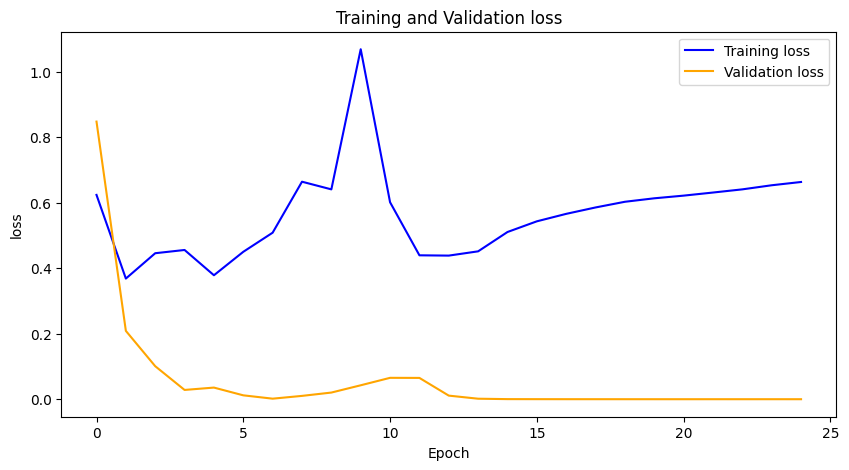

In [14]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.plot(val_loss, label='Training loss', color='blue')
plt.plot(train_loss, label='Validation loss', color='orange')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 372ms/step


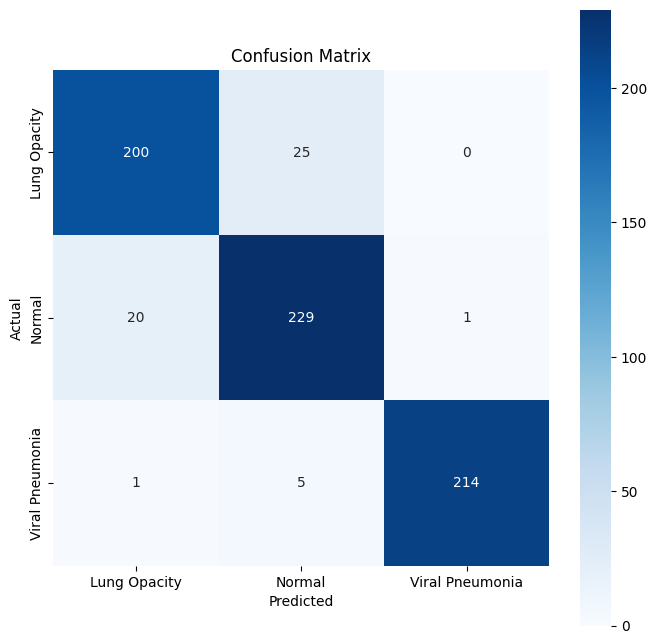

In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions for the test data
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
